In [11]:
import os
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from keras.models import save_model, load_model

def load_imgs(path, folders):
    imgs = []
    labels = []
    n_imgs = 0
    for c in folders:
        # iterate over all the files in the folder
        for f in os.listdir(os.path.join(path, c)):
            if not f.endswith('.jpg'):
                continue
            # load the image (here you might want to resize the img to save memory)
            im = Image.open(os.path.join(path, c, f)).copy()
            imgs.append(im)
            labels.append(c)
        print('Loaded {} images of class {}'.format(len(imgs) - n_imgs, c))
        n_imgs = len(imgs)
    print('Loaded {} images total.'.format(n_imgs))
    return imgs, labels

def plot_sample(imgs, labels, nrows=4, ncols=4, resize=None):
    # create a grid of images
    fig, axs = plt.subplots(nrows, ncols, figsize=(4*ncols, 4*nrows))
    # take a random sample of images
    indices = np.random.choice(len(imgs), size=nrows*ncols, replace=False)
    for ax, idx in zip(axs.reshape(-1), indices):
        ax.axis('off')
        # sample an image
        ax.set_title(labels[idx])
        im = imgs[idx]
        if isinstance(im, np.ndarray):
            im = Image.fromarray(im)  
        if resize is not None:
            im = im.resize(resize)
        ax.imshow(im, cmap='gray')


# map class -> idx
label_to_idx = {
    'CHEETAH':0,
    'OCELOT': 1,
    'SNOW LEOPARD':2, 
    'CARACAL':3,
    'LIONS': 4,
    'PUMA': 5,
    'TIGER':6
}

idx_to_label = {
    0:'CHEETAH',
    1:'OCELOT',
    2:'SNOW LEOPARD', 
    3:'CARACAL',
    4:'LIONS',
    5:'PUMA',
    6:'TIGER'
}

def make_dataset(imgs, labels, label_map, img_size):
    x = []
    y = []
    n_classes = len(list(label_map.keys()))
    for im, l in zip(imgs, labels):
        # preprocess img
        x_i = im.resize(img_size)
        x_i = np.asarray(x_i)
        
        # x_i = tf.reshape(x_i, [-1])  # flatten the image into a 1D vector
        
        # encode label
        y_i = np.zeros(n_classes)
        y_i[label_map[l]] = 1.
        
        x.append(x_i)
        y.append(y_i)
    return np.array(x).astype('float32'), np.array(y)




def save_keras_model(model, filename):
    """
    Saves a Keras model to disk.
    Example of usage:

    >>> model = Sequential()
    >>> model.add(Dense(...))
    >>> model.compile(...)
    >>> model.fit(...)
    >>> save_keras_model(model, 'my_model.h5')

    :param model: the model to save;
    :param filename: string, path to the file in which to store the model.
    :return: the model.
    """
    save_model(model, filename)


def load_keras_model(filename):
    """
    Loads a compiled Keras model saved with models.save_model.

    :param filename: string, path to the file storing the model.
    :return: the model.
    """
    model = load_model(filename)
    return model

In [12]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

# imgs, labels = load_imgs('/Dataset', ['CHEETAH' ,'OCELOT', 'SNOW LEOPARD', 'CARACAL', 'LIONS', 'PUMA', 'TIGER'])
# x, y = make_dataset(imgs, labels, label_to_idx, (224,224))
# print('x shape: {}, y shape:{}'.format(x.shape, y.shape))
# # plot_sample(imgs, labels, 5, 5, resize=(224, 224))

ValueError: mount failed

In [13]:
imgs, labels = load_imgs('/content/drive/MyDrive/Dataset', ['CHEETAH' ,'OCELOT', 'SNOW LEOPARD', 'CARACAL', 'LIONS', 'PUMA', 'TIGER'])
x, y = make_dataset(imgs, labels, label_to_idx, (224,224))
# normalization of pixel
x = x / 255.0
print('x shape: {}, y shape:{}'.format(x.shape, y.shape))
# plot_sample(imgs, labels, 5, 5, resize=(224, 224))


In [17]:
################### Task 1 ###################
# Solution go here
from numpy.random import seed
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import requests
import io
from matplotlib.colors import ListedColormap
import tensorflow as tf
from keras.callbacks import EarlyStopping
from tensorflow import keras
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Flatten, Dense


tf.random.set_seed(3)

# X_train, X_val, y_train, y_val = train_test_split(x, y, shuffle=True, train_size=0.8, random_state=1)
X_train, X_not_train, y_train, y_not_train = train_test_split(x, y, shuffle=True, train_size=0.6, random_state=1)
X_val, X_test, y_val, y_test = train_test_split(X_not_train, y_not_train, shuffle=True, test_size=0.5, random_state=1)

print(x.shape)
print(y.shape)
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

# x_flattened = tf.reshape(x, [x.shape[0], -1])
# print(x_flattened.shape)
# Define neural network architecture
model = Sequential()
model.add(Flatten(input_shape=(224, 224, 3)))  # Flatten layer to convert images to 1D vectors
model.add(Dense(128, activation='relu'))  # additional layers 128
model.add(Dense(64, activation='relu'))  # additional layers 128
model.add(Dense(7, activation='softmax'))  # Output layer with 7 classes with softmax activation function

# Prepare the computational graph and training operations
opt = tf.keras.optimizers.SGD(learning_rate= 0.0001) # Adam
model.compile(optimizer=opt, 
                loss='categorical_crossentropy', 
                metrics=['accuracy']) # acc

# we would seek a minimum for validation loss, whereas we would seek a maximum for validation accuracy  
es = EarlyStopping(monitor='val_loss', mode='min', patience=6, verbose=2) # val_accuracy

# Train the model
history = model.fit(X_train, y_train, 
                    epochs=80,
                    callbacks = [es], 
                    validation_data=(X_val, y_val),
                    batch_size=100
)
# history = model.fit(
#                     x,
#                     y,
#                     epochs=50,
#                     validation_split=0.3,
#                     shuffle=True,
#                     callbacks=[es],
#                     verbose="auto",
#                     )

# Evaluate the performance
eval_results = model.evaluate(X_test, y_test)
print('Test loss: {} - Test acc: {}'.format(*eval_results))

# print(history.history.keys())

# plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
# plt.title('Train and Validation loss')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.legend(['Train Loss', 'Validation Loss'], loc='upper left')
# plt.show()

# create another plot
train_acc = history.history['accuracy'] # acc
val_acc = history.history['val_accuracy'] # val_acc
plt.plot(range(1, len(train_acc) + 1), train_acc, label='Train Accuracy')
plt.plot(range(1, len(val_acc) + 1), val_acc, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Train and Validation Accuracy')
plt.legend()
plt.show()

# Print the model summary
# model.summary()

In [ ]:
save_keras_model(model, 'FFNN1New.h5')

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_7 (Flatten)         (None, 150528)            0         
                                                                 
 dense_21 (Dense)            (None, 128)               19267712  
                                                                 
 dense_22 (Dense)            (None, 64)                8256      
                                                                 
 dense_23 (Dense)            (None, 7)                 455       
                                                                 
Total params: 19,276,423
Trainable params: 19,276,423
Non-trainable params: 0
_________________________________________________________________
11/11 [==============================] - 0s 11ms/step - loss: 1.7764 - accuracy: 0.2840
Test loss: 1.776374340057373 - Test acc: 0.2839506268501282


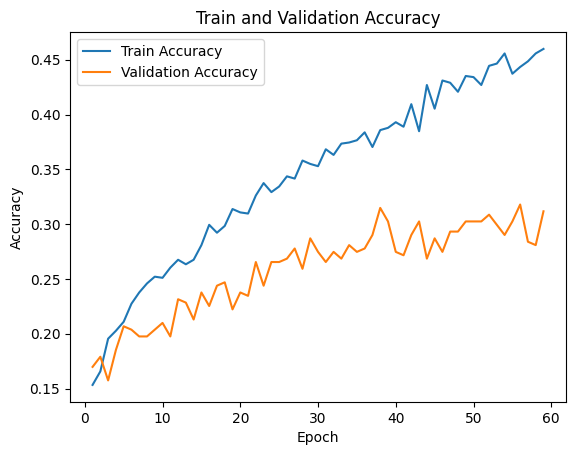

In [49]:
X_train, X_not_train, y_train, y_not_train = train_test_split(x, y, shuffle=True, train_size=0.6, random_state=1)
X_val, X_test, y_val, y_test = train_test_split(X_not_train, y_not_train, shuffle=True, test_size=0.5, random_state=1)
FFNN1 = load_keras_model('FFNN1.h5')
FFNN1.summary()
# y_predict = FFNN1.predict(X_test)
eval_results = FFNN1.evaluate(X_test, y_test)
print('Test loss: {} - Test acc: {}'.format(*eval_results))

# create another plot
train_acc = history.history['accuracy'] # acc
val_acc = history.history['val_accuracy'] # val_acc
plt.plot(range(1, len(train_acc) + 1), train_acc, label='Train Accuracy')
plt.plot(range(1, len(val_acc) + 1), val_acc, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Train and Validation Accuracy')
plt.legend()
plt.show()


In [74]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
################### Task 1 Bonus ###################
# Solution go here

X_train, X_not_train, y_train, y_not_train = train_test_split(x, y, shuffle=True, train_size=0.6, random_state=1)
X_val, X_test, y_val, y_test = train_test_split(X_not_train, y_not_train, shuffle=True, test_size=0.5, random_state=1)
# x = x / 255.0
# print(X_train.shape[0])
feature_matrix = np.zeros((224,224))
for z in range (0, X_train.shape[0]): # iterate trough each image
  for i in range (0, X_train[0].shape[0]): # iterate through heigth
    for j in range (0, X_train[0].shape[1]): # # iterate through width
        feature_matrix[i][j] = ((X_train[z][i,j,0] + X_train[z][i,j,1] + X_train[z][i,j,2])/3)
  features = np.reshape(feature_matrix, (224, 224))
  # print("feature shape", features.shape)
  input_feat = np.column_stack(features)
  # input_feat = np.concatenate(input_feat, features)
print("input_feat", input_feat.shape)

val_feature_matrix = np.zeros((224,224))
for z in range (0, X_val.shape[0]): # iterate trough each image
  for i in range (0, X_val[0].shape[0]): # iterate through heigth
    for j in range (0, X_val[0].shape[1]): # # iterate through width
        val_feature_matrix[i][j] = ((X_val[z][i,j,0] + X_val[z][i,j,1] + X_val[z][i,j,2])/3)
  val_features = np.reshape(val_feature_matrix, (224, 224))
  # print("feature shape", val_features.shape)
  val_input_feat = np.column_stack(val_features)
  # val_input_feat = np.concatenate(val_input_feat, features)
print("val_input_feat", val_input_feat.shape)

# Compute mean and variance for each channel
h_w_train_mean = np.mean(X_train, axis=(1, 2))  # Compute mean along height and width dimensions
h_w_train_var = np.var(X_train, axis=(1, 2))  # Compute variance along height and width dimensions
print("1",h_w_train_mean.shape)
print("1",h_w_train_var.shape)
color_train_mean = np.mean(X_train, axis=3)
color_train_variance = np.var(X_train, axis=3)

# color_train_mean = np.mean(X_train[:, :, :, :4], axis=(1, 2, 3))
# color_train_variance = np.var(X_train[:, :, :, :3], axis=(1, 2, 3))

print("2",color_train_mean.shape)
print("2",color_train_variance.shape)

h_w_val_mean = np.mean(X_val, axis=(1, 2))  # Compute mean along height and width dimensions
h_w_val_var = np.var(X_val, axis=(1, 2))  # Compute variance along height and width dimensions
print("3",h_w_val_mean.shape)
print("3",h_w_val_var.shape)

# color_val_mean = np.mean(X_val[:, :, :, :3], axis=(1, 2, 3))
# color_val_variance = np.var(X_val[:, :, :, :3], axis=(1, 2, 3))
color_val_mean = np.mean(X_val, axis=3)
color_val_variance = np.var(X_val, axis=3)
print("4",color_val_mean.shape)
print("4",color_val_variance.shape)

# n_animals = X_train.shape[0]
# n_CHEETAH = 240 images of class CHEETAH
# n_ = 238 images of class OCELOT
# n_ = 236 images of class SNOW LEOPARD
# n_ = 190 images of class CARACAL
# n_ = 233 images of class LIONS
# n_ = 241 images of class PUMA
# n_ = 242 images of class TIGER
# n_legendaries = y_train.sum()
# n_classes = 2
# class_weights = {0: n_animals / (n_classes * (n_animals - n_legendaries)),
#                  1: n_animals / (n_classes * n_legendaries)}

# Combine the extracted features
# features = np.column_stack((h_w_mean, h_w_var, color_mean, color_variance))

# Build the model
model = Sequential()
model.add(Dense(128, activation='relu', input_shape=(4,)))  # Input layer with 2 features
model.add(Dense(64, activation='relu'))  # Hidden layer with ReLU activation
model.add(Dense(7, activation='softmax'))  # Output layer with 7 classes and softmax activation

# Compile the model
opt = tf.keras.optimizers.Adam(learning_rate= 0.0001) # Adam
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

es = EarlyStopping(monitor='val_loss', mode='min', patience=6, verbose=2) # val_accuracy

# Train the model
history = model.fit(input_feat, y_train, epochs=80, callbacks=[es], validation_data=(val_input_feat, y_val), batch_size=100)




input_feat (224, 224)
val_input_feat (224, 224)
1 (972, 3)
1 (972, 3)
2 (972, 224, 224)
2 (972, 224, 224)
3 (324, 3)
3 (324, 3)
4 (324, 224, 224)
4 (324, 224, 224)


ValueError: ignored

In [ ]:
################# Task 2 ###################
# Solution go here

# AGUMENTATION THE DATASET

import tensorflow as tf
from tensorflow.keras import layers

X_train, X_not_train, y_train, y_not_train = train_test_split(x, y, shuffle=True, train_size=0.6, random_state=1)
X_val, X_test, y_val, y_test = train_test_split(X_not_train, y_not_train, shuffle=True, test_size=0.5, random_state=1)
# x = x / 255.0

# Define the CNN model
model = tf.keras.Sequential()

# Add the first convolutional layer
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(layers.MaxPooling2D((2, 2)))

# Add the second convolutional layer
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

# Add the third convolutional layer
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

# Flatten the feature maps
model.add(layers.Flatten())

# Add the first dense layer
model.add(layers.Dense(128, activation='relu'))

# Add the second dense layer
model.add(layers.Dense(64, activation='relu'))

# Add the output layer
model.add(layers.Dense(7, activation='softmax'))

# Compile the model
opt = keras.optimizers.Adam(learning_rate= 0.001)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

# we would seek a minimum for validation loss, whereas we would seek a maximum for validation accuracy  
es = EarlyStopping(monitor='val_loss', mode='min', patience=10, verbose=2)

# Train the model
history = model.fit(X_train, y_train, epochs=80, callbacks = [es], validation_data=(X_val, y_val))

# Evaluate the performance
eval_results = model.evaluate(X_test, y_test)
print('Test loss: {} - Test acc: {}'.format(*eval_results))

print(history.history.keys())

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

train_acc = history.history['categorical_accuracy'] # acc
val_acc = history.history['val_categorical_accuracy'] # val_acc

# Create a plot
plt.plot(range(1, len(train_acc) + 1), train_acc, label='Train Accuracy')
plt.plot(range(1, len(val_acc) + 1), val_acc, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Train and Validation Accuracy')
plt.legend()
plt.show()

# Print the model summary
model.summary()






Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 26, 26, 128)     

In [45]:
################### Task 2 Bonus ###################
# Solution go here

X_train, X_not_train, y_train, y_not_train = train_test_split(x, y, shuffle=True, train_size=0.6, random_state=1)
X_val, X_test, y_val, y_test = train_test_split(X_not_train, y_not_train, shuffle=True, test_size=0.5, random_state=1)
# x = x / 255.0
print(X_train.shape)
print(X_train[1,30,30,:])
a = np.array([[1, 2, 5], [3, 4, 5]])
print(a.shape)
print(np.mean(a, axis=0)) # per colonna
print(np.mean(a, axis=1)) # per riga
# print(np.mean(a, axis=2)) # per riga
print(np.mean(a, axis=(0,1))) # per colonna

(972, 224, 224, 3)
[0.80784315 0.42745098 0.00784314]
(2, 3)
[2. 3. 5.]
[2.66666667 4.        ]
3.3333333333333335
